<a href="https://colab.research.google.com/github/ravimashru/100-days-of-deep-learning/blob/master/docs/days/029_Custom_Training_Loop_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

In [1]:
import tensorflow as tf
import numpy as np

print('TensorFlow: ', tf.__version__)
print('NumPy: ', np.__version__)

TensorFlow:  2.3.0
NumPy:  1.18.5


In [2]:
handwritten_digits_mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = handwritten_digits_mnist.load_data()

print('Training data: ', train_images.shape, train_labels.shape)
print('Test data: ', test_images.shape, test_labels.shape)

11493376/11490434 [==============================] - 0s 0us/step
Training data:  (60000, 28, 28) (60000,)
Test data:  (10000, 28, 28) (10000,)


In [3]:
discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

In [4]:
latent_dim = 128

generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(7 * 7 * 128),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Reshape((7, 7, 128)),
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)       0 

In [5]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004)

# Instantiate a loss function.
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(real_images):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images


In [6]:
import os

# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 20  # In practice you need at least 20 epochs to generate nice digits.
save_dir = "./"

for epoch in range(epochs):
    print("\nStart epoch", epoch)

    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)

        # Logging.
        if step % 200 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))



Start epoch 0
discriminator loss at step 0: 0.71
adversarial loss at step 0: 0.70
discriminator loss at step 200: 0.20
adversarial loss at step 200: 2.77
discriminator loss at step 400: 0.51
adversarial loss at step 400: 1.27
discriminator loss at step 600: 0.39
adversarial loss at step 600: 1.58
discriminator loss at step 800: 0.35
adversarial loss at step 800: 1.84
discriminator loss at step 1000: 0.37
adversarial loss at step 1000: 1.41

Start epoch 1
discriminator loss at step 0: 0.21
adversarial loss at step 0: 2.30
discriminator loss at step 200: 0.20
adversarial loss at step 200: 2.92
discriminator loss at step 400: 0.19
adversarial loss at step 400: 3.01
discriminator loss at step 600: 0.15
adversarial loss at step 600: 3.16
discriminator loss at step 800: 0.06
adversarial loss at step 800: 4.93
discriminator loss at step 1000: 0.08
adversarial loss at step 1000: 4.06

Start epoch 2
discriminator loss at step 0: 0.06
adversarial loss at step 0: 4.10
discriminator loss at step 

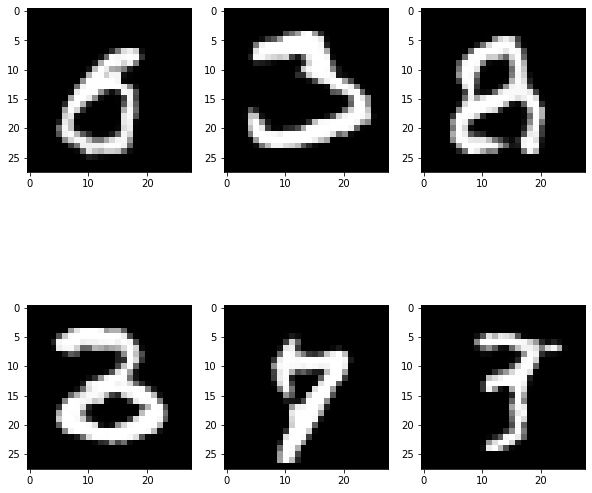

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

steps = ['0', '200', '400', '600', '800', '1000']

fig, ax = plt.subplots(2, 3, figsize=(10, 10))
for idx, step in enumerate(steps):
  img = mpimg.imread(f'generated_img{step}.png')
  ax[idx // 3][idx % 3].imshow(img, cmap='gray')
plt.show()